# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ../python
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement tensorflow==1.7.1 (from unityagents)
ERROR: No matching distribution found for tensorflow==1.7.1


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='one_agent_reacher_novis/Reacher.x86_64')
#env = UnityEnvironment(file_name='many_agents_reacher_novis/Reacher.x86_64')

#env = UnityEnvironment(file_name='many_agents_reacher/Reacher.x86_64')
env = UnityEnvironment(file_name='one_agent_reacher/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
print( env.brain_names )

['ReacherBrain']


In [4]:
from ddpg_agent import Agent
from collections import deque
import torch


In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    

# number of agents
num_agents = len(env_info.agents)

agent = Agent(state_size          = 33, 
              action_size         = 4, 
              random_seed         = 2, 
              buffer_size         = 100000,
              batch_size          = 128,
              gamma               = 0.99,
              tau                 = 1e-3,
              lr_actor            = 2e-4,
              lr_critic           = 2e-4,
              actor_weight_decay  = 0,
              critic_weight_decay = 0,
              learn_prescaler     = 0, 
              learning_cycles     = 1, 
              noise_initial_gain  = 1.0,
              noise_gain_decay    = 1.0,
              sample_every_cycle  = True, 
              gradient_limiter    = True)

/home/bmendonca/workspace/udacity/deep-reinforcement-learning/p2_continuous-control/ddpg_agent.py:170: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 6.99
Episode 200	Average Score: 16.19
Episode 300	Average Score: 24.02
Episode 400	Average Score: 29.07
Episode 500	Average Score: 30.20
Episode 600	Average Score: 30.31
Episode 700	Average Score: 29.30
Episode 800	Average Score: 28.73
Episode 900	Average Score: 26.85
Episode 1000	Average Score: 28.79


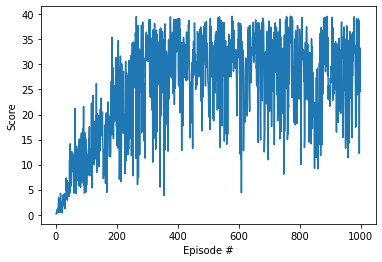

In [6]:
def ddpg(n_episodes=1000, max_t=10000, print_every=100):   
    scores_deque = deque(maxlen=print_every)
    scores = []

    
    for i_episode in range(1, n_episodes+1):
        
        states = env.reset(train_mode=True)[brain_name].vector_observations     # reset the environment    
        agent.reset()
        
        scores_episode = np.zeros(num_agents)               # rewards per episode for each agent
        
        for t in range( max_t ):
            actions     = agent.act(states)
            env_info    = env.step(actions)[brain_name]     # send all actions to tne environment
            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards     = env_info.rewards                  # get reward (for each agent)
            dones       = env_info.local_done               # see if episode finished
            
            for (state, action, reward, next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            states = next_states
            scores_episode += rewards
            
            if any(dones):
                break 
                
        
        #Averaring the mean score across all agents for this episode
        mean_score = np.mean( scores_episode )

        scores.append( mean_score )
        scores_deque.append( mean_score )
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean( scores_deque )), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean( scores_deque )))
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions     = agent.act(states)                    # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 23.61999947205186


In [ ]:
env.close()